# Swarming Itokawa with cubesats
In this example we consider a rather advanced mission option that was inspired to us by the European Space Agency
[HERA mission](https://www.esa.int/Space_Safety/Hera). HERA is an interplanetary spacecraft that will explore the binary system named Didymos in 2025.
In the case of HERA, two cubesats called Milani and [Juventas](https://www.heramission.space/hera-mission-juventas-cubesat), will detach from the main
mother satellite to perform some detailed exploration of the system, including the exploartion of its gravity field.
The use of cubesats to increase the mission scientific output, while minimizing risks connected to operating in a highly unknown environment,
is a possibility future advanced missions. 

We will show the use of cascade to study the dynamics of a large number of cubesats simultaneously orbiting an irregular body. We will study conjumctions and consider
a forbidden sphere around the asteroid the cubesats need to avoid by making use of some thrusting.

Note: this example concerns a case that has not driven the development of cascade (namely Earth debris populations). In particular the collision frequency (and reentry) is much higher if compared to the timestep induced by the Taylor integrator on the selected dynamics. As a consequence the overall algorithm becomes less efficient as dynamics computations (i.e. the Taylor coefficients) are thrown away and need to be redone each time an event is triggered.

Let us start with some imports:

In [1]:
# core imports
import pykep as pk
import numpy as np
import scipy
import pickle as pkl
import cascade as csc
import heyoka as hy
from copy import deepcopy

# plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

## Importing and defining the irregular body
In the example we are going to consider the asteroid [Itokawa](https://en.wikipedia.org/wiki/25143_Itokawa) as an example of irregular body, with the understanding that a similar study is possible for any body. We will use mascons to have a representation of irregular bodies. In other words, an asteroid to us will be a set of point masses located in specific positions with some given mass.

In [2]:
with open("data/itokawa_mascon.pk", "rb") as file:
    mascon_points, mascon_masses, name = pkl.load(file)
print(name+":", "number of mascons is", len(mascon_masses))

Itokawa: number of mascons is 41748


In the case of Itokawa, the mascon model of the body, here provided by the pickled file ``itokawa_mascon.pk`` was developed in the project [geodesyNET](https://github.com/darioizzo/geodesyNets) and correspond to a perfectly uniform density asteroid. We actually know that for the case of Itokawa that is not the case, but for the purpose of this example that is irrelevant. Some physical properties of the asteroid are defined next:

In [3]:
L = 350.44 # [m] units of length (used in the mascon model)
M = 3.51E10 # [kg] units of mass (the Itokawa mass)
G = 6.6743E-11 # [m^3/s^2/kg] units for G (the Cavendish constant)
T = np.sqrt(L**3/G/M) # [s] induced units of time
wz = 2*np.pi / (12.132 * 60. * 60. / T) # asteroid angular velocity is 12.132 hours, here computed in the selected units
w_vec = np.array([0., 0. ,wz]) # we assume a rotation around the z axis

we now visualize the mascon model:

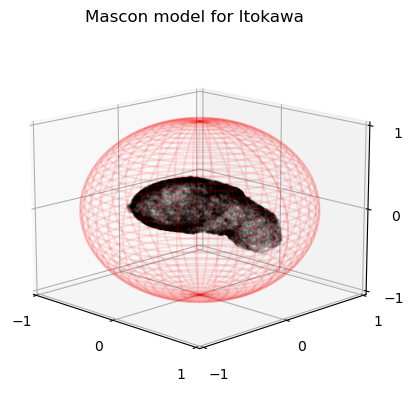

In [4]:
# Define the 3d Axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all mascons 
ax.scatter3D(mascon_points[:,0], mascon_points[:,1], mascon_points[:,2], alpha=0.03, s=1, c='k')

# Plot a safety sphere around it
r = np.sqrt(1.1)
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:40j]
X = r*np.cos(u)*np.sin(v)
Y = r*np.sin(u)*np.sin(v)
Z = r*np.cos(v)
ax.plot_wireframe(X, Y, Z, color="r", alpha=0.1)

# Set the axis limits 
limit=1
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
ax.set_zlim(-limit,limit)
ax.view_init(15,-45)
ax.set_title("Mascon model for Itokawa")
ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])
ax.set_zticks([-1,0,1]);


## Exploring the dynamics of one single cubesat
Before delving into a full cascade simulation, it is useful to investigate the dynamics of a single cubesat around the irregular body considered. We will do so using directly
[heyoka](https://bluescarni.github.io/heyoka.py/index.html), knwing that cascade smulations also use Taylor integrators for the dynamics provided via heyoka.

We provide in the ``cascade.dynamics`` module the dynamics of a spacecraft around a rotating asteroids as modelled by a mascon model. The dynamics implements the equations of motion:

$$
\left\{
\begin{array}{l}
\dot{\mathbf r} = \mathbf v \\
\dot {\mathbf v} = -G \sum_{j=0}^N \frac {m_j}{|\mathbf r - \mathbf r_j|^3} (\mathbf r - \mathbf r_j) - 2 \boldsymbol\omega \times \mathbf v - \boldsymbol \omega \times\boldsymbol\omega \times \mathbf r
\end{array}
\right.
$$

see the [Reliable event detection for Taylor methods in astrodynamics.](https://doi.org/10.1093/mnras/stac1092) published in Monthly Notices of the Royal Astronomical Society for further information on such a model. Note that we are using units where $G=1$ and $GM=1$.

In [5]:
dyn = csc.dynamics.rotating_mascon(Gconst = 1., masses=mascon_masses, points=mascon_points, omega = w_vec)

We now instantiate a Taylor integrator using [heyoka](https://bluescarni.github.io/heyoka.py/index.html)'s ``taylor_adaptive`` class. Note that we add a [terminal event](https://bluescarni.github.io/heyoka.py/notebooks/Event%20detection.html#terminal-events) to the equations so that whenever the trajectory hits the safety sphere, a manouvre is made in the form of a $\Delta \mathbf V$ that prevents the cubesat to enter the dangerous area by inverting the radial component of the spacecraft velocity.

$$
\Delta \mathbf V =  2(\mathbf {\hat r} \cdot \mathbf v) \mathbf {\hat r}
$$
where $\mathbf {\hat r}$ represents the unit vector of the spacecraft position and $\mathbf v$ its velocity.

Note how the ``taylor_adaptive`` constructor is called with the argument ``compact_mode`` set to True as otherwise the equation generation would take a considerable amount of time.

In [6]:
x,y,z = hy.make_vars("x", "y", "z")
vx,vy,vz = hy.make_vars("vx", "vy", "vz")

# Applies the DV to the spacecraft state
def apply_dv(ta, mr, d_sgn):
    global DV
    r = ta.state[:3]
    rotv = np.cross(w_vec, r)
    v = ta.state[3:6] - rotv
    ta.state[3:6] = v - 2*np.dot(r,v)/np.dot(r,r) * r + rotv
    DV+=np.linalg.norm(2*np.dot(r,v)/np.dot(r,r) * r)
    return True

# Define a terminal event that detects the entry in the safety sphere
safety_ev = hy.t_event(
        # The event equation.
        x**2+y**2+z**2 - 1.1,
        # The callback.
        callback = apply_dv)

# Constructs the Taylor integrator
taylor = hy.taylor_adaptive(sys=dyn, state = [0.,0.,0.,0.,0.,0.], compact_mode=True, t_events=[safety_ev])

We now place the cubesat in its initial conditions. We simulate an orbit starting, in the non rotating frame, from a distance $r$ and a circular velocity $\sqrt{\frac{1}{r}}$. We also simlate for enough time to see the cubesat trigger the safety event.

In [7]:
r_ic = 2.2
v_ic = np.sqrt(1./r_ic) - r_ic*wz # We use a small dv from a circular orbit to lower the pericenter
taylor.state[:] = [r_ic, 0., 0., 0., v_ic, 0.]
taylor.time=0.
tgrid = np.linspace(0., 100, 1000)
DV=0

.. and we perform the numerical propagation.

In [8]:
out = taylor.propagate_grid(tgrid)

### A single trajectory
We now first plot the cubesat trajectory, then compute the control DV that was needed to keep the cubesat at a safe distance.

In [9]:
# This helper function can be used to transform the simulation output into the inertial frame
def rotate(tgrid, states, w_vec):
    from scipy.spatial.transform import Rotation as rot
    import numpy as np
    from copy import deepcopy
    retval = deepcopy(states)
    direction = w_vec / np.linalg.norm(w_vec)
    for t, item in zip(tgrid, retval):
        R = rot.from_rotvec(t * direction).as_matrix()
        item[:3] = R@item[:3]
        item[3:6] = R@item[3:6]
    return retval
out_rotated=rotate(tgrid, out[4], -w_vec)

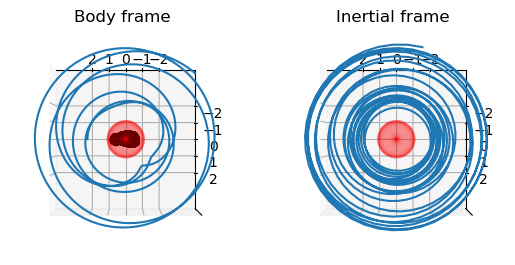

In [10]:
# Define the 3d Axis
fig = plt.figure()

#Plot in the rotatting frame
ax = fig.add_subplot(121, projection='3d')

# Plot all mascons 
ax.scatter3D(mascon_points[:,0], mascon_points[:,1], mascon_points[:,2], alpha=0.05, s=2, c='k')

# Plot the safety sphere around it
r = np.sqrt(1.1)
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:40j]
X = r*np.cos(u)*np.sin(v)
Y = r*np.sin(u)*np.sin(v)
Z = r*np.cos(v)
ax.plot_wireframe(X,Y,Z, color="r", alpha=0.1)

ax.plot3D(out[4][:,0],out[4][:,1],out[4][:,2])

limit=4
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
ax.set_zlim(-limit,limit)
ax.view_init(90,90)
ax.set_title("Body frame")
ax.set_xticks([-2, -1,0,1, 2])
ax.set_yticks([-2, -1,0,1, 2])
ax.set_zticks([]);

# Plot in the inertial frame
ax = fig.add_subplot(122, projection='3d')
# Plot the safety sphere around it
r = np.sqrt(1.1)
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:40j]
X = r*np.cos(u)*np.sin(v)
Y = r*np.sin(u)*np.sin(v)
Z = r*np.cos(v)
ax.plot_wireframe(X,Y,Z, color="r", alpha=0.1)

ax.plot3D(out_rotated[:,0],out_rotated[:,1],out_rotated[:,2])

limit=4
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
ax.set_zlim(-limit,limit)
ax.view_init(90,90)
ax.set_title("Inertial frame")
ax.set_xticks([-2, -1,0,1, 2])
ax.set_yticks([-2, -1,0,1, 2])
ax.set_zticks([]);


Note how the cubesat manouvres to avoid its entrance into the safety zone, and eventually is again expelled by the gravity field. We can even evaluate the amount of DV that is provided by the cubesat propulsion system:

In [11]:
print("Total DV: ", DV * L / T, "m/s")
print("Trajectory duration: ", taylor.time*T/60/60/24, "days")

Total DV:  0.0 m/s
Trajectory duration:  4.96078431229414 days


## Simulate cubesat swarming
We now simulate the behaviour of multiple cubesats under the same dynamics we have so far used. We also assume that each cubesat has the capability to perform avoidance manouvres when it gets too close to another element of the swarm.

We will thus instantiate a cascade simulation where each body has the same collisional radius. Upon the detection of a collision event we will perfrom an avoidance manouvre.
Upon detection of a reentry event (in this case corresponding to entering the safe sphere) we will also perform a manouvre to keep the element far from the asteroid.

We start defining the cubesats initial positions. We will assume a deployment from a circular orbit and regulate all velocities so that all cubesats have the same energy: this relates roughly to a scenario where a mother craft deploys the various cubesats along its orbit (iso-energetic)

In [12]:
# Number of cubesats to simulate
n_cubesats = 50
# Collisional radius (5m)
radius = 7. / L
# The initial state (we will then override all Cartesian components)
ic_state = np.ones((n_cubesats,7)) * radius
# Initial position and velocity magnitude for the first satellite
r_ic = 2.1
v_ic = np.sqrt(1./r_ic) - r_ic*wz 
# Energy level of the first cubesat
energy_level = csc.dynamics.rotating_mascon_energy(state = [r_ic,0,0,0,v_ic,0], Gconst = 1., points=mascon_points, masses=mascon_masses, omega=w_vec)
# We define all other cubesats with initial conditions having the same energy level
for i, state in enumerate(ic_state):
    cs = np.cos(i/n_cubesats * 2 * np.pi)
    sn = np.sin(i/n_cubesats * 2 * np.pi)
    fv = lambda v: energy_level - csc.dynamics.rotating_mascon_energy(state = [r_ic * cs, r_ic * sn, 0, -v*sn, v*cs, 0], Gconst = 1., points=mascon_points, masses=mascon_masses, omega=w_vec)
    new_v = scipy.optimize.root_scalar(fv, x0=v_ic, bracket=[v_ic-0.1, v_ic+0.1]).root
    state[0] = r_ic * cs
    state[1] = r_ic * sn
    state[2] = 0
    state[3] = - new_v * sn
    state[4] = new_v * cs
    state[5] = 0
    print(i, end=" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

We are now ready to instantiate a cascade simulation. With respect to previous examples we here need to make use of the argument ``compact_mode`` else the just in time compilation of the internal Taylor integrators will take too much time. With ``compact_mode`` we are sacrificing some optimizations in the jitted code but we allow the simulation object to be built in a few seconds only even if the mascon model has tens of thousands of mascons adding to the right hand side of the dynamics.

We have also added an ``exit_radius`` as to be able to trigger events when cubesats are going too far from the center and thus keep the entire swarm always close to the asteroid. 

In [13]:
# Number of collisional timesteps to be processed in parallel.
n_par_ct = 100
# Timestep of the simulation
simulation_step = 2 * np.pi / 20.
# Collisional timestep
collisional_step = simulation_step / n_par_ct
# Re-entry event
safety_radius = 1.1
# Exit event
exit_radius = 3.
# The simulation object
sim = csc.sim(ic_state, collisional_step, dyn=dyn, reentry_radius=safety_radius, n_par_ct = 100, compact_mode=True, exit_radius = exit_radius)

We now run a simulation where collisions are avoided by a virtual elastic collision (using cubesat $DV$)
and all cubesats are forced to remain within the exit and the safety radius (using cubesat $DV$).

In [14]:
# Simulation length in time units
final_t = 4 * pk.DAY2SEC / T
# We will store for each cubesat the cumulated DV
DV = np.zeros(n_cubesats)
# Counters
n_coll, n_sm, n_am = 0, 0, 0
# We store the positions of the events
ev_pos = []
# We also store the position of all cubesats at the end of each step
all_pos = deepcopy(ic_state)
# Start of the simulation
while sim.time < final_t:
    # One step
    oc = sim.step()
    # Appending the cubesat positions
    all_pos = np.concatenate((all_pos, sim.state))
    # Cleaning the print
    print("\r                                                                              ",end='')
    # Printing time
    print(f"\rTime: {sim.time:3.3f}", end='')

    # Checking events
    if oc == csc.outcome.collision:
        pi, pj = sim.interrupt_info
        # Collision Avoidance Manouvre
        print(" - CAM:", pi,pj, end='')
        # sat i inertial state
        ri = deepcopy(sim.state[pi][:3])
        vroti =  np.cross(w_vec, ri)
        vi = sim.state[pi][3:6] - vroti
        # sat j inertial state
        rj = deepcopy(sim.state[pj][:3])
        vrotj =  np.cross(w_vec, rj)
        vj = sim.state[pj][3:6] - vrotj
        # Elastic collision: the velocity components along rij are exchanged
        rij = (ri-rj) / np.linalg.norm(ri-rj)
        vi_r = np.dot(vi, rij) * rij
        vj_r = np.dot(vj, rij) * rij
        vi = vi - vi_r + vj_r
        vj = vj - vj_r + vi_r
        # ... in the rotating frame
        sim.state[pi][3:6] = vi + vroti
        sim.state[pj][3:6] = vj + vrotj
        # Updating DVs
        DV_mag = np.linalg.norm(vj_r-vi_r)
        DV[pi]+= DV_mag
        DV[pj]+= DV_mag
        # Updating the number of collisions counter and the event positions
        n_coll+=1
        ev_pos.append(ri)

    if oc == csc.outcome.reentry:
        pi = sim.interrupt_info
        # Safety Manouvre
        print(" - SM:", pi, end='')
        # sat i inertial state
        ri = deepcopy(sim.state[pi][:3])
        vrot = np.cross(w_vec, ri)
        vi = sim.state[pi][3:6] - vrot
        # Inverting the radial inertial velocity component and transforming back to the rotating frame
        hatr = ri / np.linalg.norm(ri)
        sim.state[pi][3:6] = vi - 2*np.dot(hatr,vi) * hatr + vrot
        # Updating DVs
        DV[pi]+=np.linalg.norm(2*np.dot(hatr,vi) * hatr)
        # Updating the number of safety manouvres counter and the event positions
        n_sm+=1
        ev_pos.append(ri)

    if oc == csc.outcome.exit:
        pi = sim.interrupt_info
        # Re-approach Manouvre
        print(" - reAM:", pi, end='')
        # sat i inertial state
        ri = deepcopy(sim.state[pi][:3])
        vrot = np.cross(w_vec, ri)
        vi = sim.state[pi][3:6] - vrot
        # Inverting the radial inertial velocity component and transforming back to the rotating frame
        hatr = ri / np.linalg.norm(ri)
        sim.state[pi][3:6] = vi - 2*np.dot(hatr,vi) * hatr + vrot
        # Updating DVs
        DV[pi]+=np.linalg.norm(2*np.dot(hatr,vi) * hatr)
        # Updating the number of safety manouvres counter and the event positions
        n_am+=1
        ev_pos.append(ri)

ev_pos = np.array(ev_pos)
print("\nNumber of collisions: ", n_coll)
print("Number of safety manouvres: ", n_sm)
print("Number of re-approach manouvres: ", n_am)

Time: 80.821 - reAM: 6                                                        
Number of collisions:  44
Number of safety manouvres:  74
Number of re-approach manouvres:  196


We plot the cubesats positions and the positions of all manouvres.

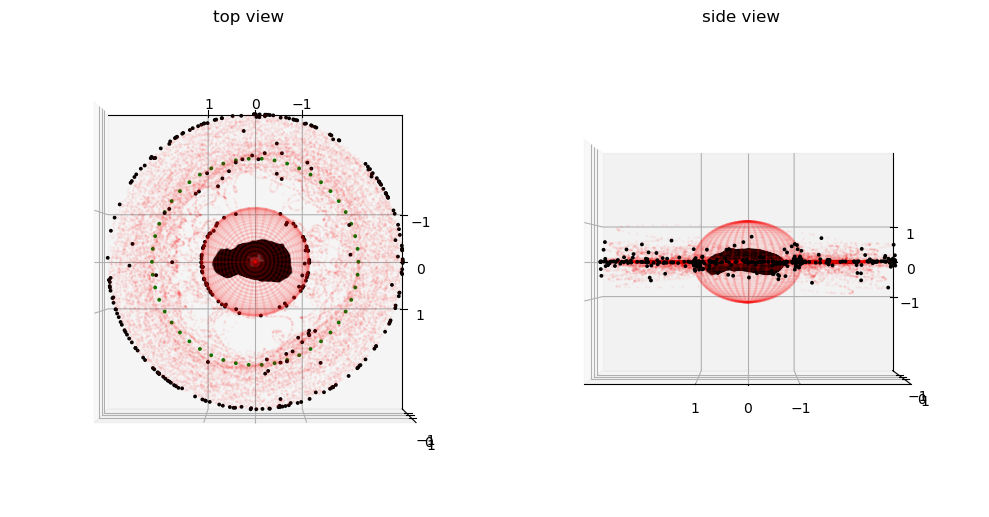

In [17]:
def plot_swarm(az, el, ax, title):
    # Plot all mascons 
    ax.scatter3D(mascon_points[:,0], mascon_points[:,1], mascon_points[:,2], alpha=0.03, s=1, c='k')

    # Plot swarm
    ax.scatter3D(all_pos[:,0], all_pos[:,1], all_pos[:,2], alpha=0.03, s=1, c='r')

    # Plot events
    ax.scatter3D(ev_pos[:,0], ev_pos[:,1], ev_pos[:,2], alpha=1., s=3., c='k')

    # Plot initial state
    ax.scatter3D(ic_state[:,0], ic_state[:,1], ic_state[:,2], alpha=1., s=3., c='g')

    # Plot a safety sphere around it
    r = 1.1
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:40j]
    X = r*np.cos(u)*np.sin(v)
    Y = r*np.sin(u)*np.sin(v)
    Z = r*np.cos(v)
    ax.plot_wireframe(X, Y, Z, color="r", alpha=0.1)

    # Set the axis limits 
    limit=3
    ax.set_xlim(-limit,limit)
    ax.set_ylim(-limit,limit)
    ax.set_zlim(-limit,limit)
    ax.view_init(15,-45)
    ax.set_title(title)
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_zticks([-1,0,1])
    ax.view_init(az, el)
    return ax

# Define the 3d Axis
fig = plt.figure(figsize = (10,20))
ax = fig.add_subplot(121, projection='3d')
plot_swarm(90,90,ax, "top view")
ax = fig.add_subplot(122, projection='3d')
plot_swarm(0,90,ax, "side view")
plt.tight_layout()

We also plot the $DV$ distribution.

Text(0, 0.5, 'DV consumption [m/s]')

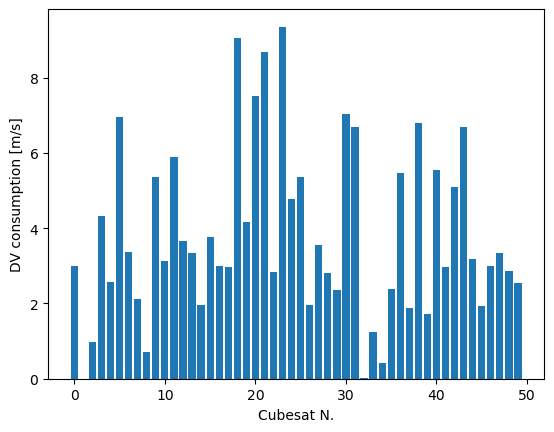

In [16]:
fig = plt.figure()
plt.bar(range(n_cubesats), DV)
plt.xlabel("Cubesat N.")
plt.ylabel("DV consumption [m/s]")

That is all folks! Pretty cool if you ask me.